In [1]:
import matplotlib.pyplot as plt
import spectral

from pathlib import Path
import numpy as np
import dask.array as da
from spectral import open_image, remove_continuum, kmeans

In [2]:
from hyperspec.from_napari_sediment.get_roi_and_mask import load_project_params

path_export_folder = Path(
    r"\\hlabstorage.dmz.marum.de\scratch\AEGIS\Cambodia\Cambodia VNIR\qd_CAM2506_60-90cm_2025-08-27_08-45-01\napari"
)
params = load_project_params(path_export_folder)

In [3]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_im_main_roi
from hyperspec.from_napari_sediment.get_roi_and_mask import get_mask_main

# passing mainroi_index=None gives the entire dataset
imcube = get_im_main_roi(path_export_folder, mainroi_index=0)
imcube = da.moveaxis(imcube, 0, -1)
mask = get_mask_main(path_export_folder) > 0

img = open_image(params.file_path)
bands = np.array(img.bands.centers)
metadata = img.metadata
rgb_channels = np.array(metadata['default bands']).astype(int)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


# Spectral indices

In [25]:
def get_img_for_wavelength(lam, array3D):
    idx = np.argmin(np.abs(bands - lam))

    return array3D[:, :, idx]

def NDCI(array3D):
    """Normalized difference chlorophyll index"""
    R_705 = get_img_for_wavelength(705, array3D)
    R_665 = get_img_for_wavelength(670, array3D)
    return ((R_705 - R_665) / (R_705 + R_665)).compute()

def RABD670(array3D):
    """Chl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_670 = get_img_for_wavelength(670, array3D)
    R_640 = get_img_for_wavelength(640, array3D)
    R_695 = get_img_for_wavelength(695, array3D)
    return ((19 * R_640 + 16 * R_695) / 35 / R_670).compute()

def RABD842(array3D):
    """BChl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_790 = get_img_for_wavelength(790, array3D)
    R_900 = get_img_for_wavelength(900, array3D)
    R_842 = get_img_for_wavelength(695, array3D)
    return ((33 * R_790 + 36 * R_900) / 99 / R_842).compute()

def RABD620(array3D):
    """phycocyanin"""
    center = 620
    left = 600
    right = 640
    R_center = get_img_for_wavelength(center, array3D)
    R_left = get_img_for_wavelength(left, array3D)
    R_right = get_img_for_wavelength(right, array3D)
    X_right = right - center
    X_left = center - left
    return ((X_right * R_left + X_left * R_right) / (X_right + X_left) / R_center).compute()

def CI(array3D):
    """Cyanobacteria index"""
    R_560 = get_img_for_wavelength(560, array3D)
    R_665 = get_img_for_wavelength(665, array3D)
    R_705 = get_img_for_wavelength(705, array3D)
    return -((R_665 - R_560) - (R_705 - R_560) * (665 - 560) / (705 - 560)).compute()

def PHY(array3D):
    return get_img_for_wavelength(620, array3D).compute()

def scale(img, quantile=.05):
    lower = np.nanquantile(img, quantile)
    upper = np.nanquantile(img, 1 - quantile)

    img[img < lower] = lower
    img[img > upper] = upper

    img -= np.nanmin(img)
    img /= np.nanmax(img)

    return img


In [26]:
def plot_index(img, fig=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=2, sharey=True, layout='tight', figsize=(4, 8))

    img[mask] = np.nan

    mask_rows = (~np.isnan(img)).mean(axis=1) > .1
    axs[0].imshow(scale(img), extent=[0, 3, 90, 60])
    axs[1].plot(np.nanmean(img[mask_rows, :], axis=1), np.linspace(60, 90, phy.shape[0])[mask_rows], c='k', linewidth=.25)
    axs[1].set_xlabel('index')
    axs[0].set_ylabel('Depth (cm)')
    return fig, axs


In [27]:
ndci = NDCI(imcube)
ndci[mask] = np.nan

chl_a = RABD670(imcube)
chl_a[mask] = np.nan

bchl_a = RABD842(imcube)
bchl_a[mask] = np.nan

ci = CI(imcube)
ci[mask] = np.nan

phy = RABD620(imcube)
phy[mask] = np.nan

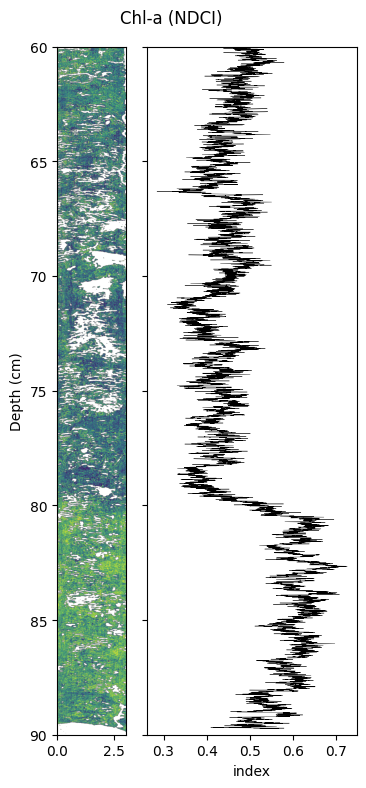

In [29]:
# scale
fig, axs = plot_index(ndci)
fig.suptitle('Chl-a (NDCI)')
plt.savefig("NDCI.png", dpi=300)

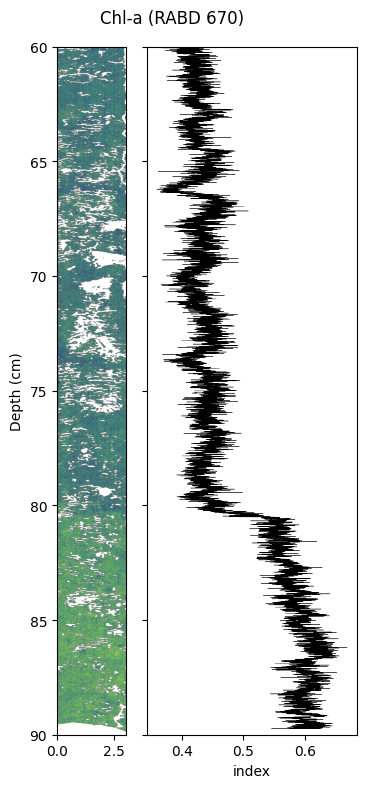

In [30]:
fig, axs = plot_index(chl_a)
fig.suptitle('Chl-a (RABD 670)')
plt.savefig("RABD670.png", dpi=300)

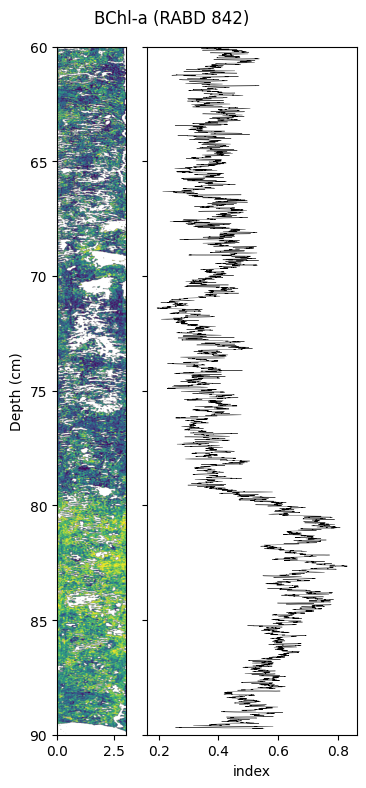

In [31]:
fig, axs = plot_index(bchl_a)
fig.suptitle('BChl-a (RABD 842)')
plt.savefig("RABD842.png", dpi=300)

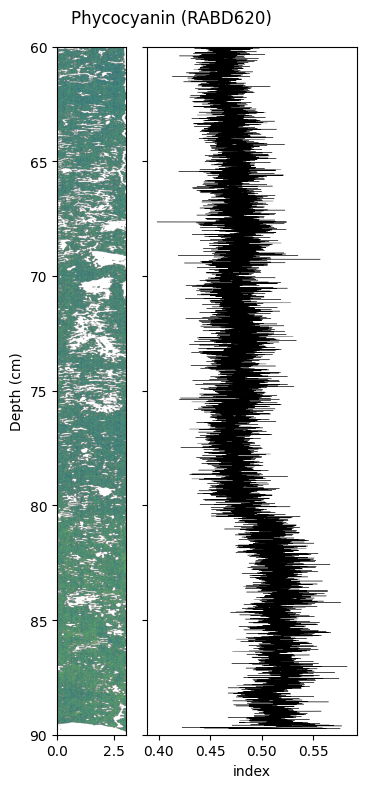

In [33]:
# scale
fig, axs = plot_index(phy)
fig.suptitle('Phycocyanin (RABD620)')
plt.savefig("RABD620.png", dpi=300)